# ***The Mongoose prototype***

For this demonstration of the Mongoose prototype, we will try to connect PertMod to MTL by combining:

*   An established MTL approach like **UnitedNet**
*   A PertMod tool like **GenKI** for digital KOs

Objective:
*   Retrieve KO-responsive genes by GenKI
*   Trace these genes to different micro-anatomical regions on the DBiT-seq through SHAP explainability





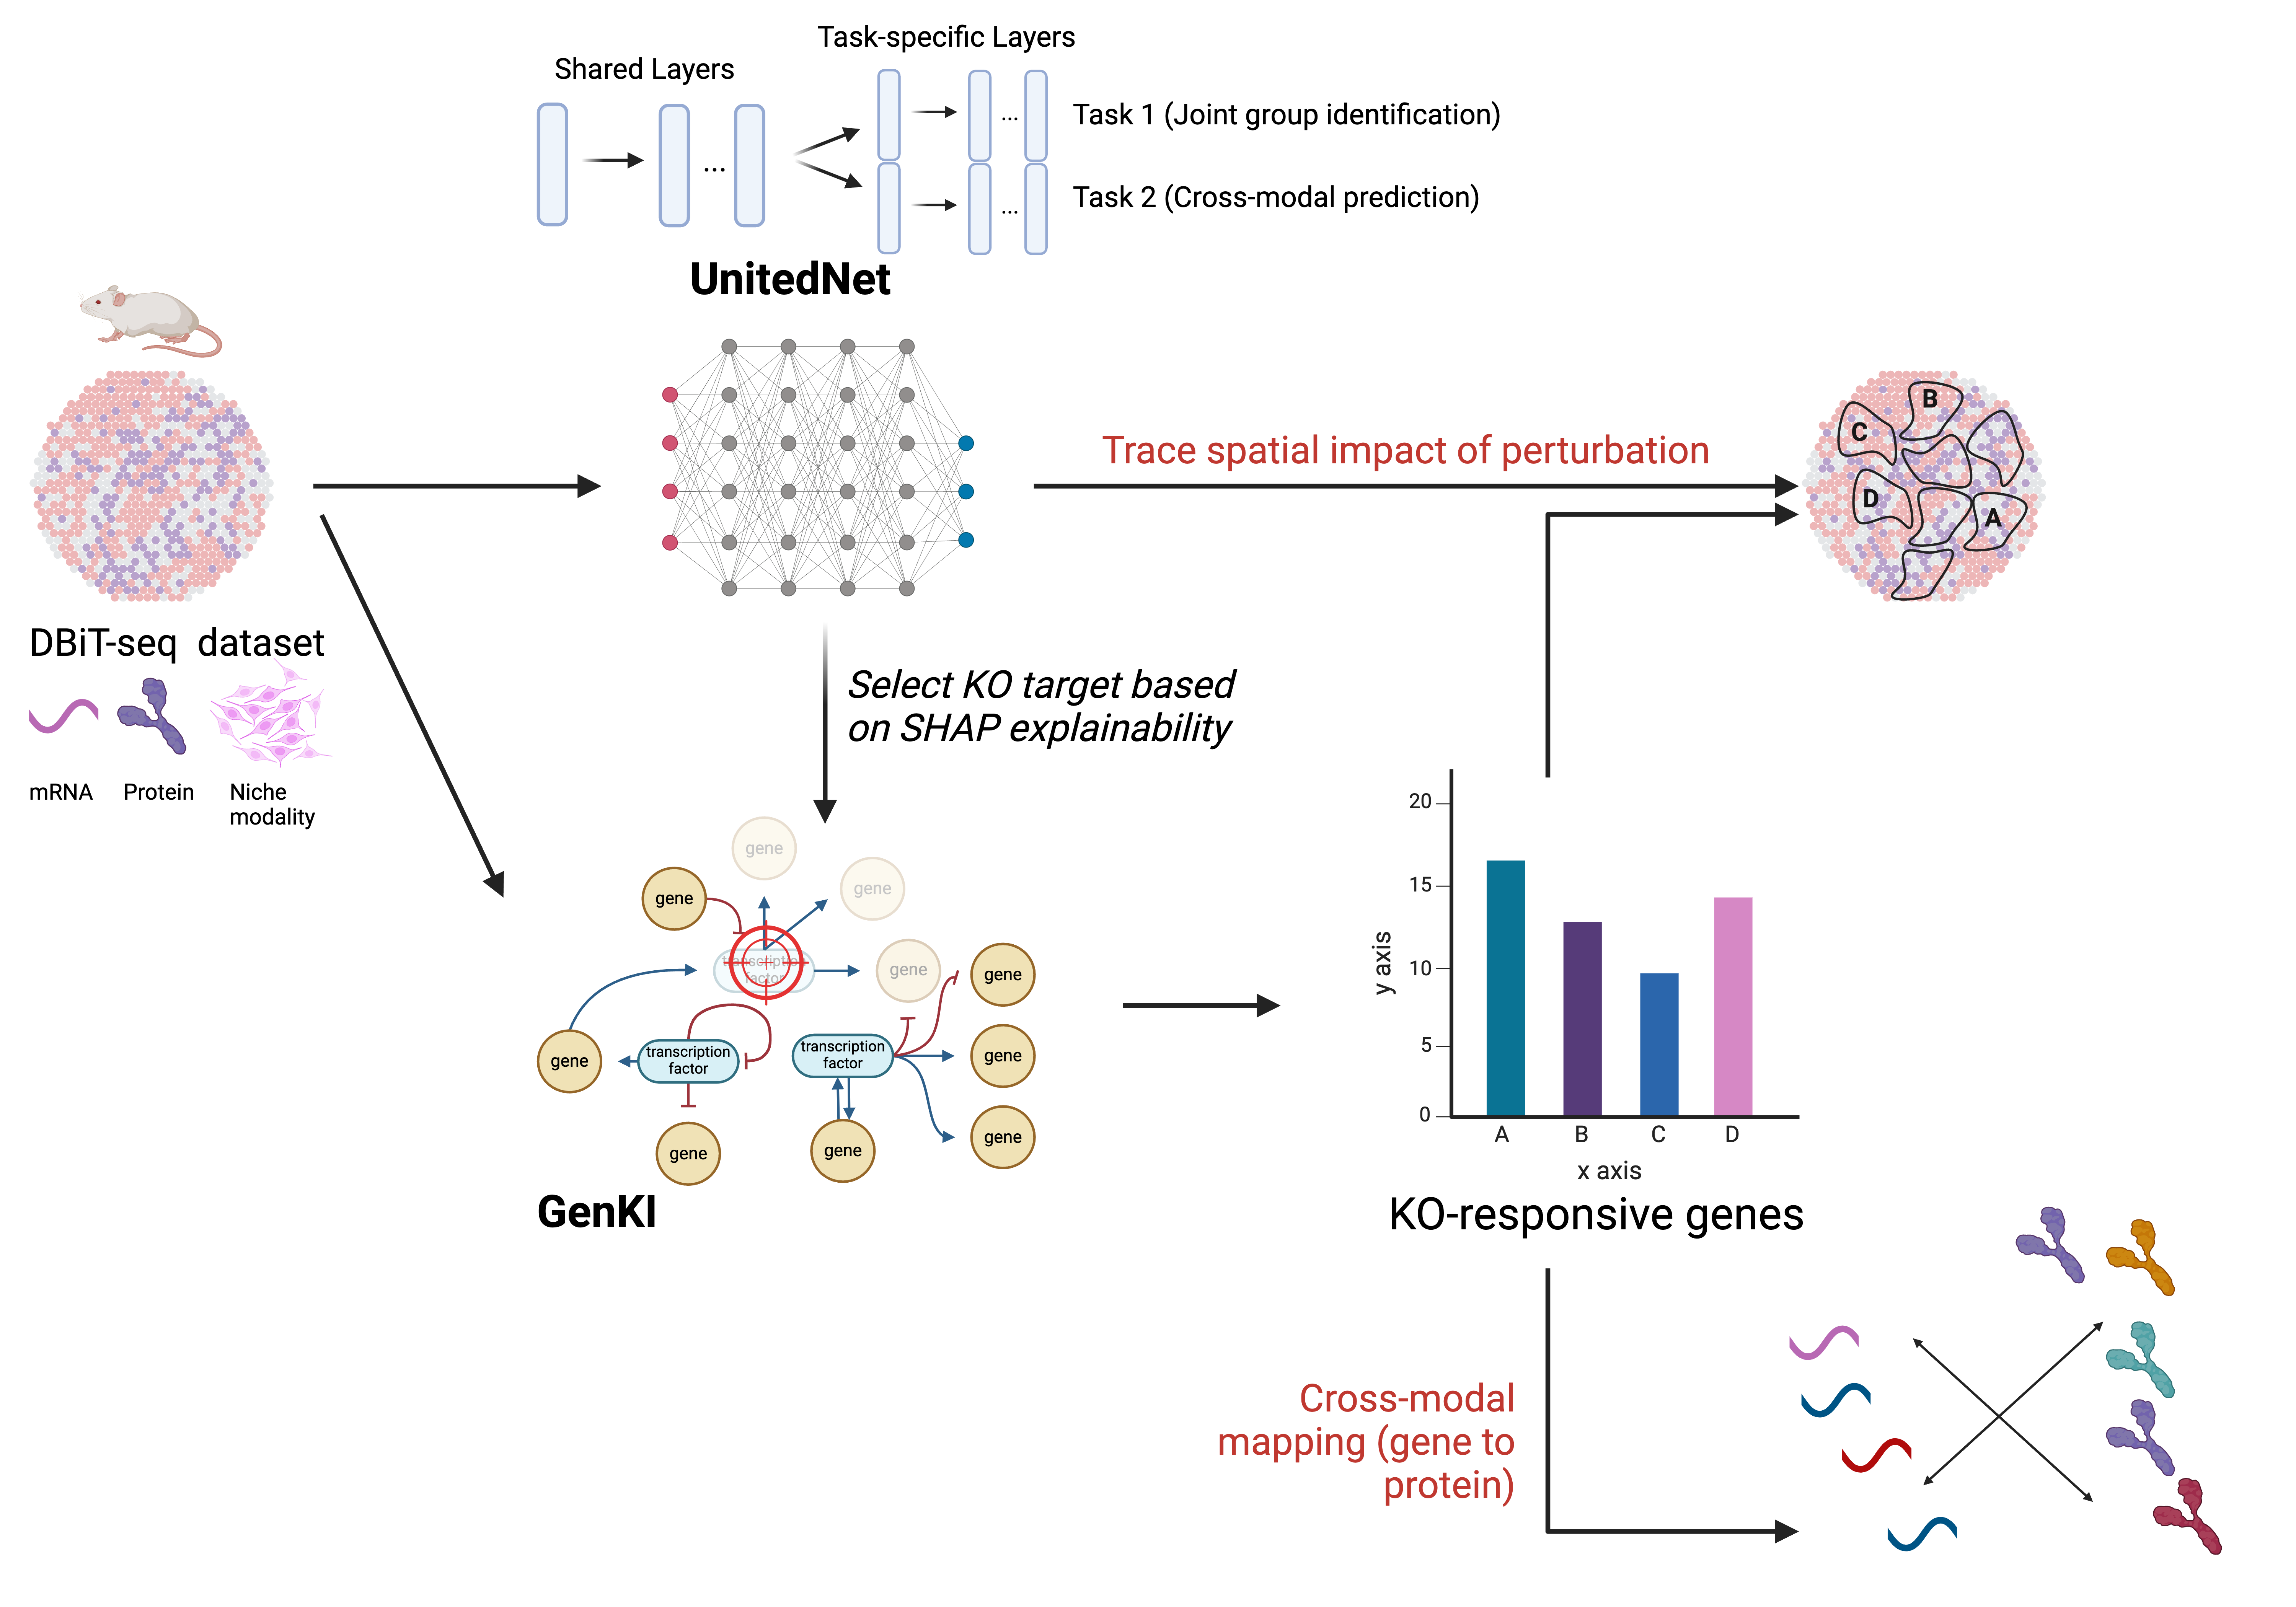

This is an overview on what we are trying to accomplish here. Showcasing the added value of pursuing multi-task learning in perturbation modelling by combining an existing MTL arcitecture (UnitedNet) with a perturbation modelling tool like GenKI to:

*   Trace the spatial impact of a digital KO
*   Trace the impact of the digital KO across modalities (genes, proteins)



# Digital KOs with GenKI on DBiT-seq



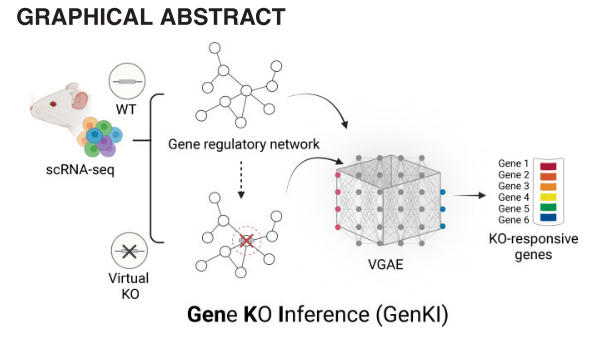

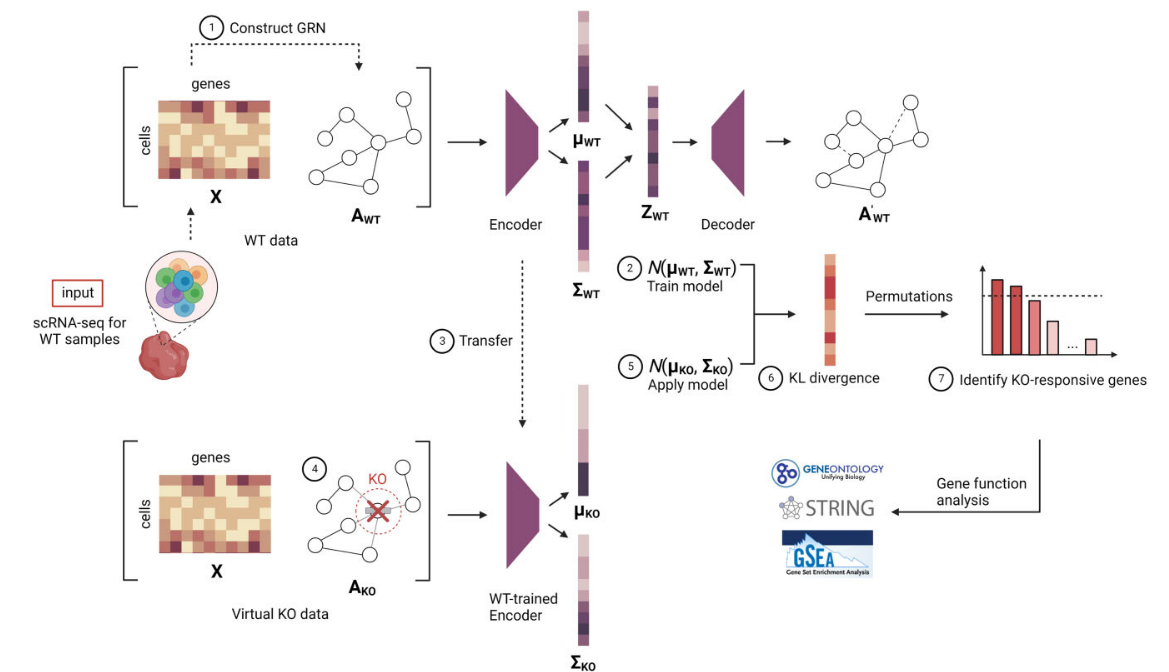

The pipeline contains seven steps:

*   ( 1 ) construction of WT scGRN,
*   ( 2 ) training VGAE (Variational Graph Autoencoder)model

*   ( 3 ) transfer the trained VGAE model
*   ( 4 ) construction of virtual KO data

*   ( 5 ) latent embeddings of WT and virtual KO data,
*   ( 6 ) calculation of KL di v ergence

*   ( 7 ) identification of KO-responsive genes
for function annotation and analysis.

The VGAE model receives as input the virtual KO data and obtains the latent distribution of the g-th gene for the KO samples. Then, the model calculates the KL (Kullback-Leibler) divergence between these two normal distributions. The procedure is repeated for all genes. The top 5% of genes ranked by the KL divergence were preserved.

Kullback-Leibler divergence metric (relative entropy) is a statistical measurement from information theory that is commonly used to quantify the difference between one probability distribution from a reference probability distribution.

Our dataset of choice is the DBiT-seq dataset concerning a mouse embryo, which stands for deterministic barcoding in tissue for spatial omics sequencing (DBiT-seq) for co-mapping of mRNAs and proteins in a formaldehyde-ﬁxed tissue slide via next-generation sequencing (NGS) (https://doi.org/10.1016/j.cell.2020.10.026)

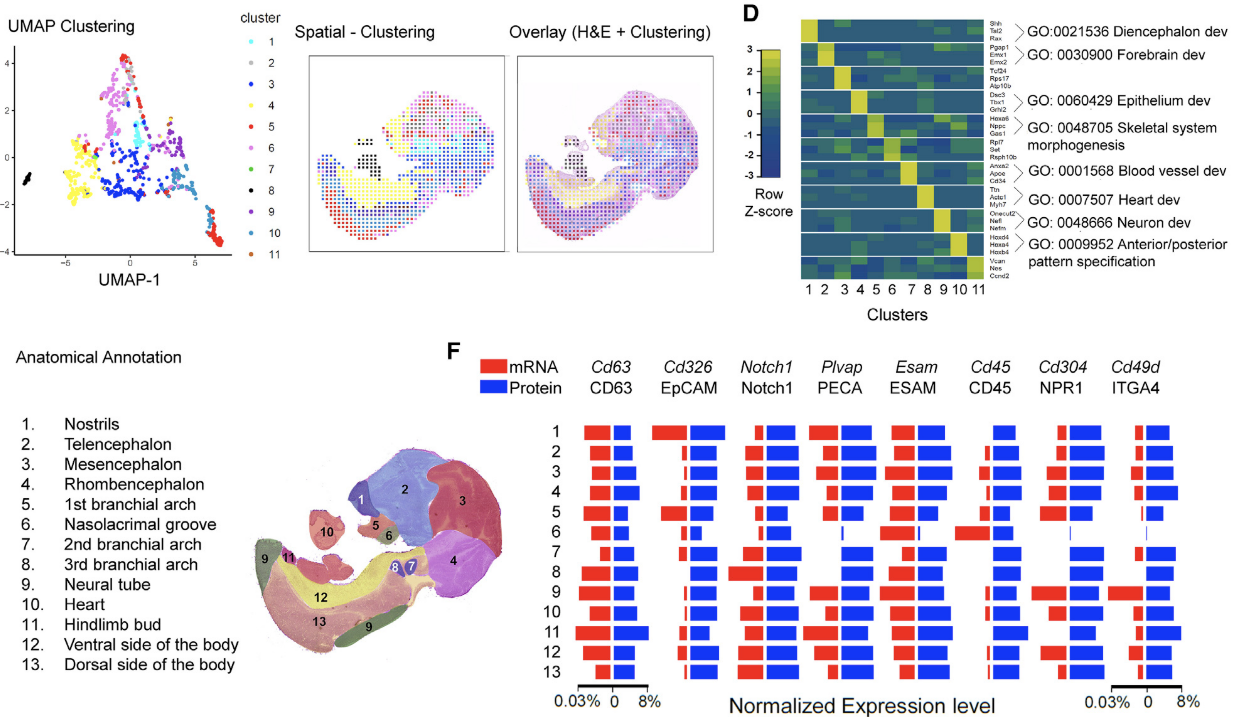

In [ ]:
## In the next step you will be asked to Cancel or Restart Kernel. Choose cancel and proceed.

In [1]:
# Install GenKI and torch_geometric as a prerequisite
! pip install git+https://github.com/yjgeno/GenKI.git
! pip install torch_geometric

# Install STRINGdb and Networkx for network biology models
! pip install stringdb
! pip install networkx pandas

  Cloning https://github.com/yjgeno/GenKI.git to /tmp/pip-req-build-5v3t8f58
  Running command git clone --filter=blob:none --quiet https://github.com/yjgeno/GenKI.git /tmp/pip-req-build-5v3t8f58
  Resolved https://github.com/yjgeno/GenKI.git to commit 6d69789b89859eda75ac75dfb1cc00ef190ada41
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 32.4 MB/s eta 0:0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.1 MB/s eta 0:00:00


In [ ]:
# RESTART KERNEL HERE!!!!!!!!!!!!!

In [ ]:
# Restart kernel
import os
os.kill(os.getpid(), 9)

In [ ]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

sc.settings.verbosity = 0

In [ ]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import GenKI as gk
from GenKI.preprocesing import build_adata
from GenKI.dataLoader import DataLoader
from GenKI.train import VGAE_trainer
from GenKI import utils

%load_ext autoreload
%autoreload 2

In [4]:
# Import STRINGdb for PPI network models and Networkx for visualisation and potential graph analysis
import stringdb
import networkx as nx

In [5]:
# Libraries for data wrangling on the adata object
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

In [6]:
# Download the DBiT-seq dataset suitable for this workshop
!gdown  1D3AIjshsAiIOktmFrvMgqKO1UKiQSPbu

# Assemble adata object for single-cell analysis
adata = sc.read("DBiTseq_UnitedNet.h5ad")
adata

Downloading...
From: https://drive.google.com/uc?id=1D3AIjshsAiIOktmFrvMgqKO1UKiQSPbu
To: /content/DBiTseq_UnitedNet.h5ad
100% 2.36M/2.36M [00:00<00:00, 16.7MB/s]


AnnData object with n_obs × n_vars = 936 × 568
    obs: 'id', 'array_row', 'array_col', 'cell_type', 'batch', 'imagecol', 'imagerow', 'label', 'sample'
    var: 'gene_ids-0', 'gene_ids-1'
    obsm: 'spatial'

## Gpc3 digital KO

In [7]:
# Let's commence with creating a digital KO of Gpc3 expression in the DBiT-seq mouse embryo dataset.
gene_of_interest = "Gpc3"

# Verify that the gene of interest is part of the rownames in adata.var
if gene_of_interest in adata.var.index:
    print(f"The gene {gene_of_interest} is present in the rownames of adata.var.")
else:
    print(f"The gene {gene_of_interest} is not present in the rownames of adata.var.")

The gene Gpc3 is present in the rownames of adata.var.


In [8]:
# adata pre-processing to prepare for input in the GenKI tool
adata.layers["norm"] = adata.X.copy()

# The adata.X should be normalised-scaled AND in sparse matrix format!
if not issparse(adata.X):
    sparse_matrix = csr_matrix(adata.X)
    adata.X = sparse_matrix
    print("Converted adata.X to a sparse matrix.")
else:
    print("adata.X is already a sparse matrix.")

Converted adata.X to a sparse matrix.


In [9]:
# load data

data_wrapper =  DataLoader(
                adata, # adata object
                target_gene = [gene_of_interest], # KO gene name
                target_cell = None, # obsname for cell type, if none use all
                obs_label = "ident", # colname for genes
                GRN_file_dir = "GRNs", # folder name for GRNs
                rebuild_GRN = True, # whether build GRN by pcNet
                pcNet_name = "DBiTseq_example", # GRN file name
                verbose = True, # whether verbose
                n_cpus = 8, # multiprocessing
                )

data_wt = data_wrapper.load_data()
data_ko = data_wrapper.load_kodata()

use all the cells (936) in adata
build GRN


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-12 11:35:23,311	INFO worker.py:1783 -- Started a local Ray instance.


ray init, using 8 CPUs
execution time of making pcNet: 160.55 s
GRN has been built and saved in "GRNs/DBiTseq_example.npz"
init completed



In [10]:
#Changed the hyperparameters to better adapt to the spatial dataset in hand

hyperparams = {
    "epochs": 300,  # Increased epochs for more training
    "lr": 5e-2,  # Adjusted learning rate
    "beta": 5e-4,  # Increased beta for stronger regularization
    "seed": 8096  # Trying a different seed
}


log_dir = None

sensei = VGAE_trainer(
    data_wt,
    epochs=hyperparams["epochs"],
    lr=hyperparams["lr"],
    log_dir=log_dir,
    beta=hyperparams["beta"],
    seed=hyperparams["seed"],
    verbose=False,
)

In [11]:
# %%timeit
sensei.train()

In [12]:
sensei.save_model('model_example_DBiTseq')

save model parameters to model/model_example_DBiTseq.th


In [13]:
# get distance between wt and ko

z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)
dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")
print(dis.shape)

(568,)


In [14]:
# raw ranked gene list

res_raw = utils.get_generank(data_wt, dis, rank=True)
res_raw.head(10)

dis  rank
Gpc3    348585.428917     1
Prrx1        0.779735     2
Rbp1         0.703830     3
Col2a1       0.697915     4
Cxcl12       0.677563     5
Meis1        0.630145     6
Glra1        0.622791     7
Sox9         0.544582     8
Hmcn1        0.517063     9
Fzd2         0.444054    10

In [ ]:
res_raw.to_csv('Gpc3_res_raw.csv')

In [ ]:
!pwd

/content


Top 20 Pathways:
21                  Regulation of neuron differentiation
20                        Mesenchymal cell proliferation
19     Positive regulation of mesenchymal cell prolif...
146     Decreased width of hypertrophic chondrocyte zone
145                            Abnormal joint morphology
144                Abnormal Meckels cartilage morphology
143                     Abnormal neurocranium morphology
142                                  Decreased body size
18                                 Cochlea morphogenesis
17                            Nervous system development
16                                    Embryo development
13                                 Notochord development
14                                    Limb morphogenesis
15                                 Cartilage development
12               Cell surface receptor signaling pathway
11                                Cartilage condensation
10                           Skeletal system development
141           

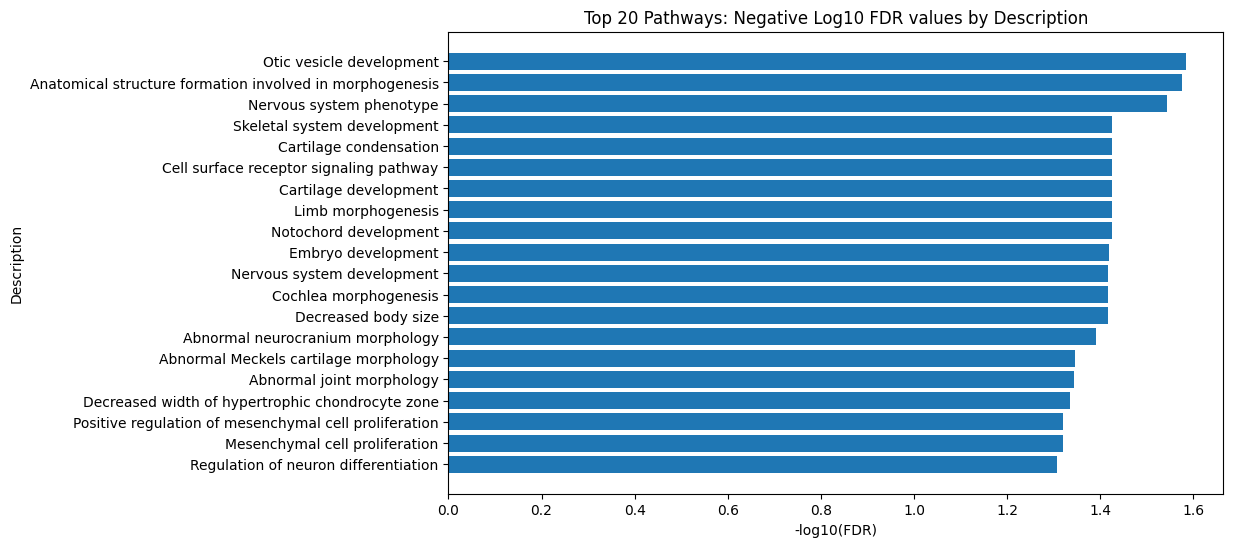

In [15]:
# Let's create a STRINGdb network of the targets affected by the gene_of_interest digital KO on the DBiT-seq dataset
genes = list(res_raw.index[1:10,])

string_ids = stringdb.get_string_ids(genes, species = 10090)   # human is 'species=9606'

# Performe pathway enrichment
enrichment_df = stringdb.get_enrichment(string_ids.queryItem, species = 10090)
enrichment_df
df = enrichment_df
sorted_df = df.sort_values(by='fdr', ascending=False)

# Select the top 10 pathways to visualise
top_20_pathways = sorted_df['description'].head(20)

print("Top 20 Pathways:")
print(top_20_pathways)

# Plotting negative log10 of FDR values against description to discern most significant pathways
plt.figure(figsize=(10, 6))
plt.barh(sorted_df['description'].head(20), -1 * sorted_df['fdr'].head(20).apply(lambda x: math.log10(x)))
plt.xlabel('-log10(FDR)')
plt.ylabel('Description')
plt.title('Top 20 Pathways: Negative Log10 FDR values by Description')
plt.show()

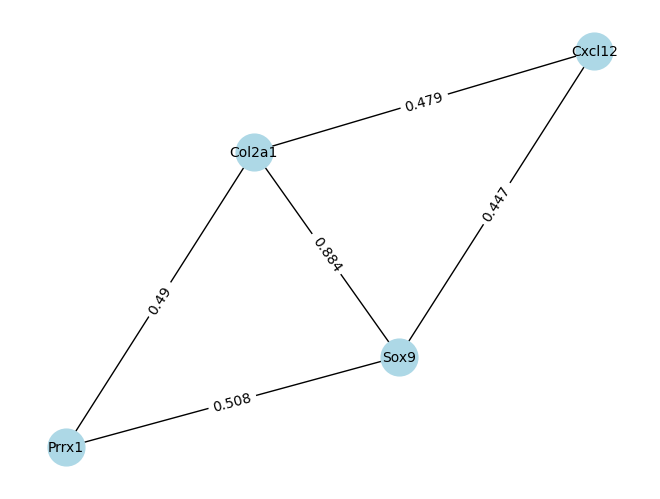

In [16]:
# Preparing visualization of STRINGdb network with Networkx
network_df = stringdb.get_network(string_ids.queryItem, species = 10090, required_score=400)
df = network_df
G = nx.Graph()
for index, row in df.iterrows():
    G.add_edge(row['preferredName_A'], row['preferredName_B'], weight=row['score'])

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)

# Draw edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [ ]:
# DISCONNECT KERNEL AND RESTART

# UnitedNet on DBiT-seq

Spatial omics simultaneously measure spatially resolved multi-omics data in intact tissue networks. UnitedNet extracts the cell neighborhood information asanadditionalmodality together with other modalities for unsupervised/supervised group identiﬁcation and cross-
modal prediction.

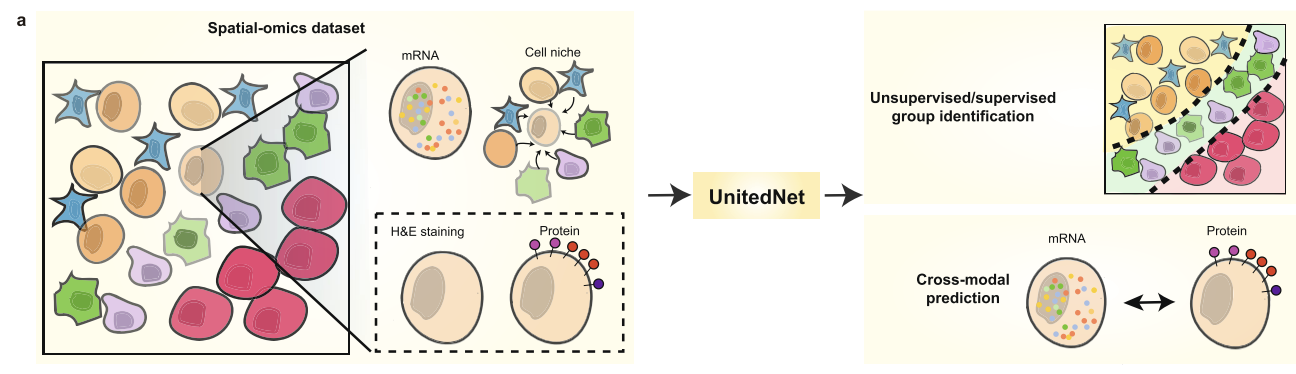

UnitedNet introduces the context "Niche Modality":


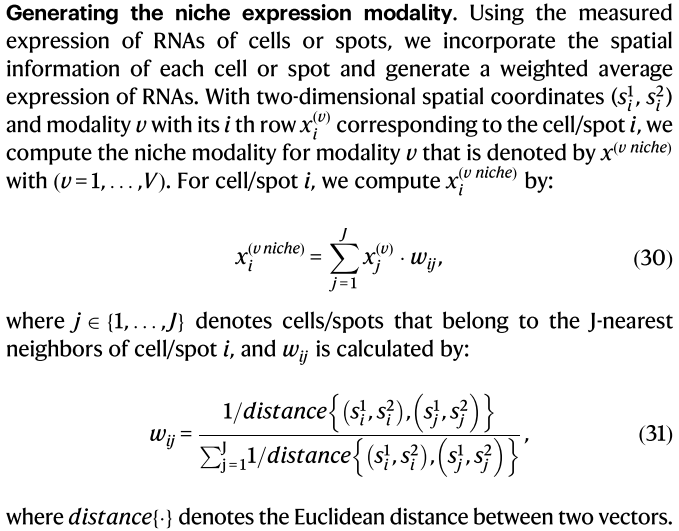

These are the ground-truth labels provided by the original DBiT-seq dataset

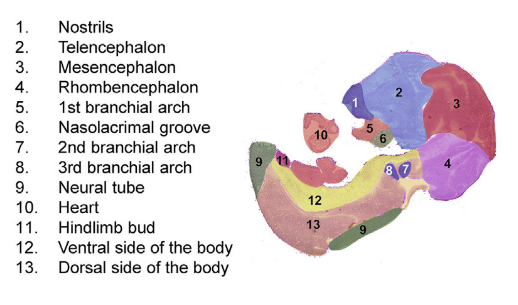

In [17]:
! pip install STRINGdb

In [18]:
import stringdb

# Here we read the file feature_feature_importance.csv that is produced by the JUPYTERNOTEBOOK.

# STRINGdb: UnitedNet + GenKI

In [20]:
import pandas as pd

# Load the data from CSV file
file_path = 'feature_feature_importance.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Define the list of genes of interest
updated_genes_list = ['Gpc3', 'Prrx1', 'Rbp1', 'Col2a1', 'Cxcl12', 'Meis1', 'Glra1', 'Sox9', 'Hmcn1', 'Fzd2']

# Filter data for the genes of interest
filtered_data = data[data['Source'].isin(updated_genes_list)]

# Separate data for RNA -> Niche and RNA -> Protein directions
rna_niche_data = filtered_data[filtered_data['Direction'] == 'RNA -> Niche']
rna_protein_data = filtered_data[filtered_data['Direction'] == 'RNA -> Protein']

# Find the top 3 unique RNA -> Niche and RNA -> Protein interactions with the highest 'Value'
top_rna_niche = rna_niche_data.sort_values(by='Value', ascending=False).drop_duplicates(subset=['Source', 'Target']).groupby('Source').head(3)
top_rna_protein = rna_protein_data.sort_values(by='Value', ascending=False).drop_duplicates(subset=['Source', 'Target']).groupby('Source').head(3)

# Identify cases where the 'Target' value is the same as the 'Source' value
rna_protein_duplicates = top_rna_protein[top_rna_protein['Target'] == top_rna_protein['Source']]
rna_niche_duplicates = top_rna_niche[top_rna_niche['Target'] == top_rna_niche['Source']]

# Remove duplicate entries from the original top lists
top_rna_protein_cleaned = top_rna_protein[~(top_rna_protein['Target'] == top_rna_protein['Source'])]
top_rna_niche_cleaned = top_rna_niche[~(top_rna_niche['Target'] == top_rna_niche['Source'])]

# Find the next highest entries for those with matching 'Target' and 'Source'
next_rna_protein = rna_protein_data[~rna_protein_data.isin(rna_protein_duplicates)].sort_values(by='Value', ascending=False)
next_rna_protein_add = next_rna_protein.groupby('Source').apply(lambda x: x[~x['Target'].isin(top_rna_protein_cleaned['Target'])].head(1)).reset_index(drop=True)

next_rna_niche = rna_niche_data[~rna_niche_data.isin(rna_niche_duplicates)].sort_values(by='Value', ascending=False)
next_rna_niche_add = next_rna_niche.groupby('Source').apply(lambda x: x[~x['Target'].isin(top_rna_niche_cleaned['Target'])].head(1)).reset_index(drop=True)

# Combine the original top lists with the added entries
final_top_rna_protein = pd.concat([top_rna_protein_cleaned, next_rna_protein_add]).sort_values(by=['Source', 'Value'], ascending=[True, False]).groupby('Source').head(3)
final_top_rna_niche = pd.concat([top_rna_niche_cleaned, next_rna_niche_add]).sort_values(by=['Source', 'Value'], ascending=[True, False]).groupby('Source').head(3)

# Combine all results into a single DataFrame
combined_df = pd.concat([final_top_rna_protein, final_top_rna_niche])

# Save the results to a single sheet in an Excel file
output_path = 'Top_RNA_Niche_Protein_Interactions_Single_Sheet_Gpc3.xlsx'  # Replace with your desired output path
with pd.ExcelWriter(output_path) as writer:
    combined_df.to_excel(writer, sheet_name='Top Interactions', index=False)

print(f"Results have been saved to {output_path}")


Results have been saved to Top_RNA_Niche_Protein_Interactions_Single_Sheet_Gpc3.xlsx


Top 20 Pathways:
120                       Regulation of cellular process
119    Positive regulation of transmembrane receptor ...
118    Positive regulation of cellular component orga...
117                  Positive regulation of MAPK cascade
2                 Intrinsic component of plasma membrane
116                                Notochord development
115                               Definitive hemopoiesis
113                               Cartilage condensation
114                           Aortic valve morphogenesis
112    Regulation of cell proliferation involved in h...
111                    Extracellular matrix organization
110                 Positive regulation of cell adhesion
109                                    Brain development
108                                         Ossification
107                                  Heart morphogenesis
106              Embryonic skeletal system morphogenesis
105             Cellular response to endogenous stimulus
104           

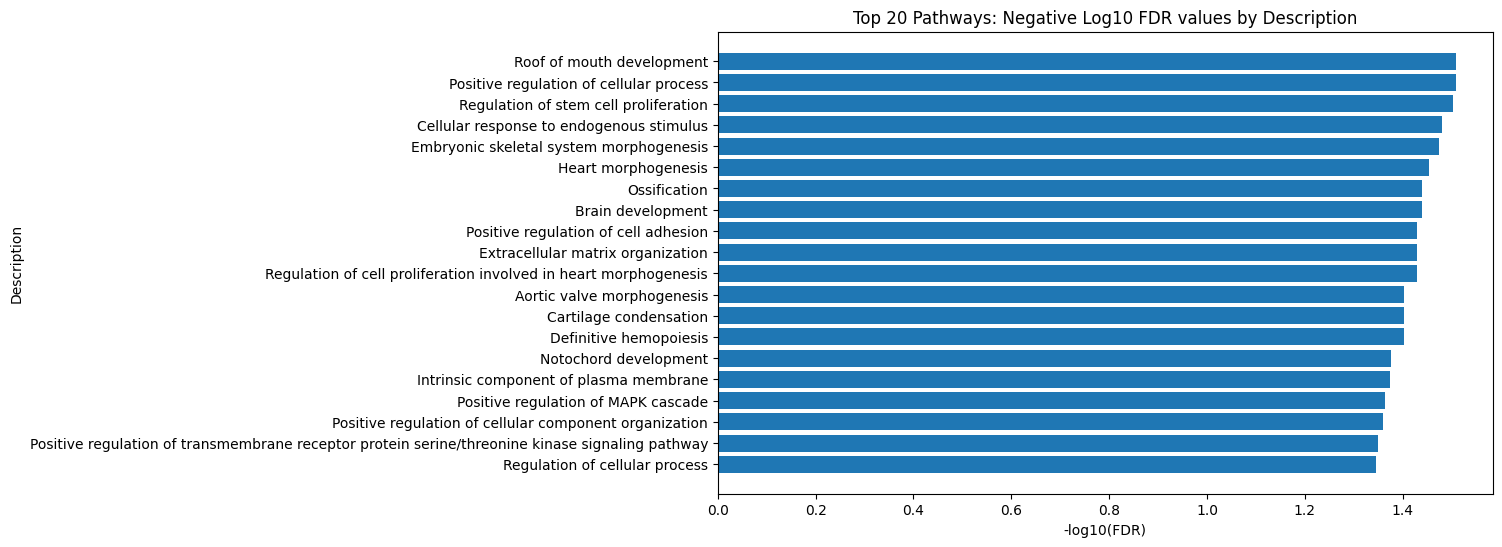

In [21]:
genes = ['Gpc3',  'Prrx1', 'Rbp1', 'Col2a1', 'Cxcl12', 'Meis1', 'Glra1', 'Sox9', 'Hmcn1', 'Fzd2', 'P2RY12',
    'CD304.NPR1', 'CD309.KDR', 'Rchy1', 'Mif', 'Hsbp1', 'MAdCAM.1', 'CD201.EPCR', 'CD63', 'Slc1a2',
    'Hoxb4', 'Msx3', 'CD304.NPR1', 'SiglecH.SIGLEC', 'CD201.EPCR', 'Zfp157', 'Dab2', 'Polr2j', 'CD55',
    'Notch1', 'P2RY12', 'Fzd4', 'Cnn1', 'Tgfbi'
]

string_ids = stringdb.get_string_ids(genes, species = 10090)   # human is 'species=9606'

# Performe pathway enrichment
enrichment_df = stringdb.get_enrichment(string_ids.queryItem, species = 10090)
enrichment_df
df = enrichment_df
sorted_df = df.sort_values(by='fdr', ascending=False)

# Select the top 10 pathways to visualise
top_20_pathways = sorted_df['description'].head(20)

print("Top 20 Pathways:")
print(top_20_pathways)

# Plotting negative log10 of FDR values against description to discern most significant pathways
plt.figure(figsize=(10, 6))
plt.barh(sorted_df['description'].head(20), -1 * sorted_df['fdr'].head(20).apply(lambda x: math.log10(x)))
plt.xlabel('-log10(FDR)')
plt.ylabel('Description')
plt.title('Top 20 Pathways: Negative Log10 FDR values by Description')
plt.savefig('top_20_pathways.svg', format='svg')
plt.show()

unit Top 20 Pathways:
1    Cell surface
0    Cell surface
Name: description, dtype: object


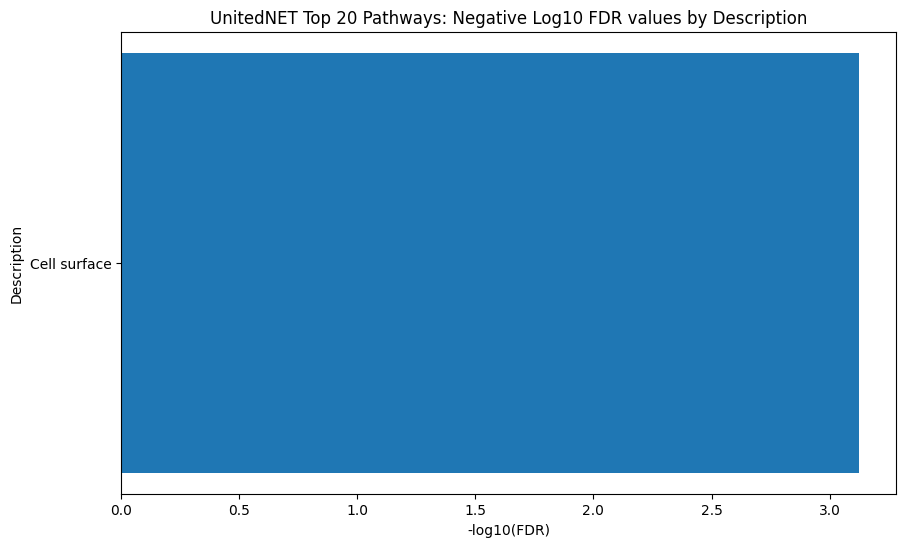

In [22]:
# UnitedNet

genes = [
    'Gpc3','P2RY12', 'CD304.NPR1', 'CD309.KDR', 'Rchy1', 'Mif', 'Hsbp1', 'MAdCAM.1', 'CD201.EPCR', 'CD63',
    'Slc1a2', 'Hoxb4', 'Msx3', 'CD304.NPR1', 'SiglecH.SIGLEC', 'CD201.EPCR', 'Zfp157', 'Dab2', 'Polr2j',
    'CD55', 'Notch1', 'P2RY12', 'Fzd4', 'Cnn1', 'Tgfbi'
]




string_ids = stringdb.get_string_ids(genes, species = 10090)   # human is 'species=9606'

# Perform pathway enrichment
unit_enrichment_df = stringdb.get_enrichment(string_ids.queryItem, species = 10090)
unit_enrichment_df
unit_df = unit_enrichment_df
unit_sorted_df = unit_df.sort_values(by='fdr', ascending=False)

# Select the top 10 pathways to visualise
unit_top_20_pathways = unit_sorted_df['description'].head(20)

print("unit Top 20 Pathways:")
print(unit_top_20_pathways)

# Plotting negative log10 of FDR values against description to discern most significant pathways
plt.figure(figsize=(10, 6))
plt.barh(unit_sorted_df['description'].head(20), -1 * unit_sorted_df['fdr'].head(20).apply(lambda x: math.log10(x)))
plt.xlabel('-log10(FDR)')
plt.ylabel('Description')
plt.title('UnitedNET Top 20 Pathways: Negative Log10 FDR values by Description')
plt.savefig('unit_top_20_pathways.svg', format='svg')
plt.show()


unit_filtered_df = unit_enrichment_df[unit_enrichment_df['description'].str.contains('Nephro|Kidney|Wilms|Ureteric', case=False, na=False)]






In [ ]:
unit_filtered_df.to_csv('unit_filtered_df_gpc3.csv')

mong Top 20 Pathways:
104    Regulation of cell proliferation involved in h...
103    Negative regulation of transcription, DNA-temp...
101            Positive regulation of biological process
102              Embryonic skeletal system morphogenesis
100                                  Locomotory behavior
99               Positive regulation of cellular process
240                         Abnormal hindlimb morphology
114                                             Homeobox
97                         Skeletal system morphogenesis
98                 Regulation of stem cell proliferation
115                                               Signal
239          Abnormal hematopoietic stem cell physiology
238                                Abnormal angiogenesis
237                     Abnormal bone marrow cell number
236                       Abnormal cartilage development
234                    Abnormal developmental patterning
235              Neonatal lethality, complete penetrance
96       

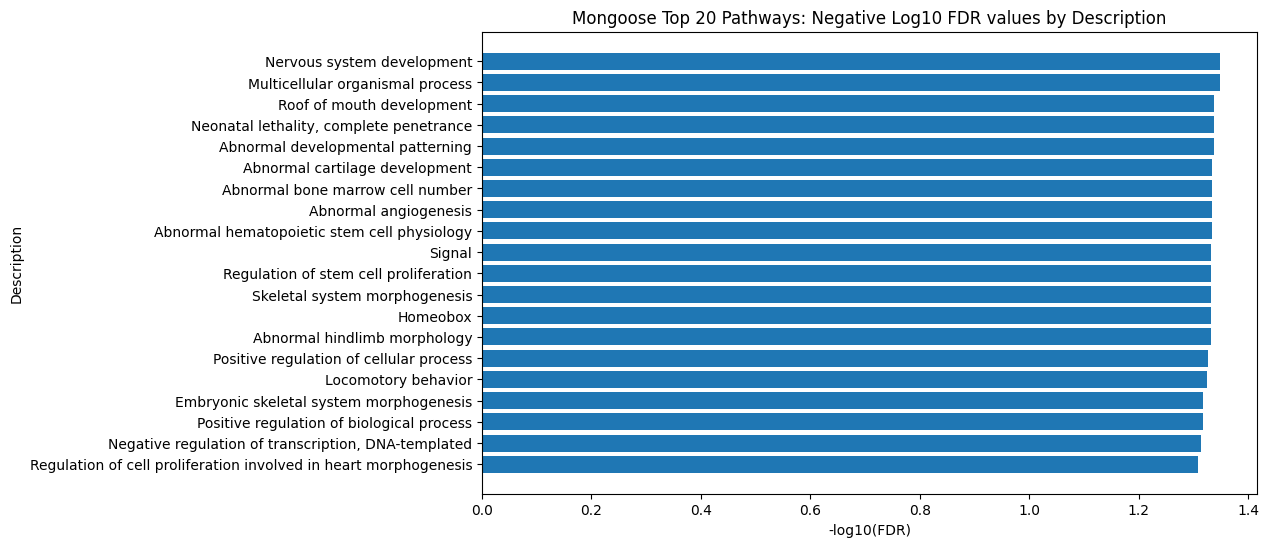

In [23]:
# Mongoose genes to STRINGdb

genes = ['Gpc3',  'Prrx1', 'Rbp1', 'Col2a1', 'Cxcl12', 'Meis1', 'Glra1', 'Sox9', 'Hmcn1', 'Fzd2', 'P2RY12',
    'NPR1', 'CD309.KDR', 'Rchy1', 'Mif', 'Hsbp1', 'MAdCAM.1', 'EPCR', 'CD63', 'Slc1a2',
    'Hoxb4', 'Msx3', 'NPR1', 'Siglech', 'EPCR', 'Zfp157', 'Dab2', 'Polr2j', 'CD55',
    'Notch1', 'P2RY12', 'Fzd4', 'Cnn1', 'Tgfbi'
]

string_ids = stringdb.get_string_ids(genes, species = 10090)   # human is 'species=9606'

# Performe pathway enrichment
mong_enrichment_df = stringdb.get_enrichment(string_ids.queryItem, species = 10090)
mong_enrichment_df
mong_df = mong_enrichment_df
mong_sorted_df = mong_df.sort_values(by='fdr', ascending=False)

# Select the top 10 pathways to visualise
mong_top_20_pathways = mong_sorted_df['description'].head(20)

print("mong Top 20 Pathways:")
print(mong_top_20_pathways)

# Plotting negative log10 of FDR values against description to discern most significant pathways
plt.figure(figsize=(10, 6))
plt.barh(mong_sorted_df['description'].head(20), -1 * mong_sorted_df['fdr'].head(20).apply(lambda x: math.log10(x)))
plt.xlabel('-log10(FDR)')
plt.ylabel('Description')
plt.title('Mongoose Top 20 Pathways: Negative Log10 FDR values by Description')
plt.savefig('mong_top_20_pathways.svg', format='svg')
plt.show()


mong_filtered_df = mong_enrichment_df[mong_enrichment_df['description'].str.contains('Nephro|Kidney|Wilms|Ureteric', case=False, na=False)]

In [ ]:
mong_filtered_df.to_csv('mong_filtered_df_gpc3.csv')

Top 20 Pathways:
37                                      Bone development
191                          Limbs/digits/tail phenotype
35                            Nervous system development
36                  Regulation of neuron differentiation
190             Increased hematopoietic stem cell number
189                    Abnormal temporal bone morphology
34     Cartilage development involved in endochondral...
188                 Abnormal digestive system morphology
187      Decreased common myeloid progenitor cell number
179              Abnormal intervertebral disk morphology
180                       Abnormal vertebrae development
181                          Abnormal humerus morphology
176                               Disproportionate dwarf
183                Abnormal hyaline cartilage morphology
184                      Abnormal chondrocyte physiology
185            Neonatal lethality, incomplete penetrance
175                                  Decreased body size
174           

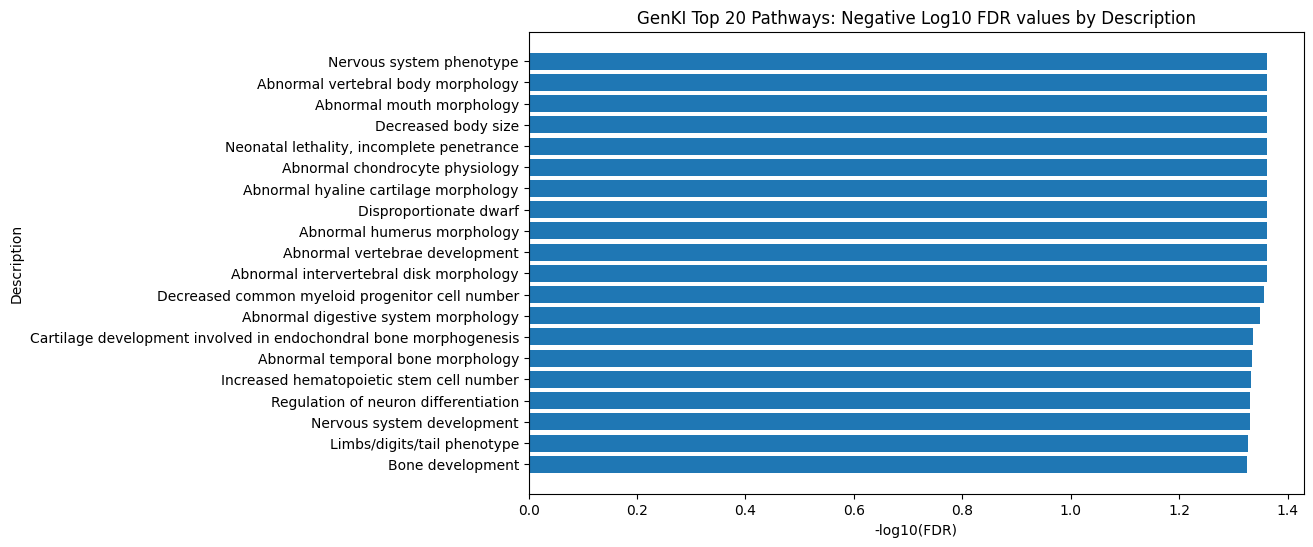

In [25]:
# GenKI genes to STRINGdb

genki_genes = ['Gpc3', 'Prrx1', 'Rbp1', 'Col2a1', 'Cxcl12', 'Meis1', 'Glra1', 'Sox9', 'Hmcn1', 'Fzd2']


string_ids = stringdb.get_string_ids(genki_genes, species = 10090)   # human is 'species=9606'

# Performe pathway enrichment
genki_enrichment_df = stringdb.get_enrichment(string_ids.queryItem, species = 10090)
genki_enrichment_df
genki_df = genki_enrichment_df
genki_sorted_df = genki_df.sort_values(by='fdr', ascending=False)

# Select the top 10 pathways to visualise
genki_top_20_pathways = genki_sorted_df['description'].head(20)

print("Top 20 Pathways:")
print(genki_top_20_pathways)

# Plotting negative log10 of FDR values against description to discern most significant pathways
plt.figure(figsize=(10, 6))
plt.barh(genki_sorted_df['description'].head(20), -1 * genki_sorted_df['fdr'].head(20).apply(lambda x: math.log10(x)))
plt.xlabel('-log10(FDR)')
plt.ylabel('Description')
plt.title('GenKI Top 20 Pathways: Negative Log10 FDR values by Description')
plt.savefig('GENKI_gpc3_top_20_pathways.svg', format='svg')
plt.show()


In [26]:
genki_filtered_df = genki_enrichment_df[genki_enrichment_df['description'].str.contains('Nephro|Kidney|Wilms|Ureteric', case=False, na=False)]

In [ ]:
genki_filtered_df.to_csv('genki_filtered_df.csv')